In [1]:
import pandas as pd
from pathlib import Path
import pickle
from sklearn.metrics import roc_auc_score
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

In [2]:
path=Path('./data')

In [3]:
# train_p1 = pd.read_feather(path/'train_p1_transformed.feather')
# train_p2 = pd.read_feather(path/'train_p2_transformed.feather')
# train_p2 = pd.read_feather(path/'data_new_users_transformed.feather')
# val_p1 = pd.read_feather(path/'val_p1_transformed.feather')
# val_p2 = pd.read_feather(path/'val_p2_transformed.feather')

train_p2 = pd.read_feather(path/'train_m_transformed.feather')
val_p1 = pd.read_feather(path/'val_m_transformed.feather')

In [ ]:
train_p2 = train_p2.append(val_p1).reset_index(drop=True)

In [ ]:
train_p2.shape, val_p1.shape, val_p2.shape

In [4]:
train_p2 = train_p2.drop(index=train_p2[train_p2['content_type_id']==1].index, columns = ['content_type_id']).reset_index(drop=True)
val_p1 = val_p1.drop(index=val_p1[val_p1['content_type_id']==1].index, columns = ['content_type_id']).reset_index(drop=True)
# val_p2 = val_p2.drop(index=val_p2[val_p2['content_type_id']==1].index, columns = ['content_type_id']).reset_index(drop=True)

In [5]:
train_p2.shape, val_p1.shape, #val_p2.shape

((23630479, 21), (3433724, 21))

In [ ]:
train_p2_val_p1 = train_p2.append(val_p1).reset_index(drop=True)

In [ ]:
train_p2_val_p1.shape

In [ ]:
target = 'answered_correctly'
# features = list(train_p2_val_p1.columns)
features = list(val_p1.columns)
features.remove('user_id')
features.remove(target)

In [ ]:
print(features)

In [ ]:
cont_nn = ['prior_question_elapsed_time',
           'question_mean', 'question_std', 'question_skew', 'time_between',
           'question_cumcount','target_cumsum', 'prior_question_elapsed_time_cumsum', 'user_mean',
           'time_per_question', 'timestamp_prior_time_cumsum_diff']

cat_nn = ['content_id', 'prior_question_had_explanation', 'bundle_id',
          'part', 'num_of_tags', 'bundle_size']

In [ ]:
train_idx = train_p2_val_p1[:len(train_p2)].index
val_idx = train_p2_val_p1[len(train_p2):].index

In [ ]:
splits = (list(train_idx),list(val_idx))

In [ ]:
procs_nn = [Categorify,
            FillMissing,
            Normalize]

In [ ]:
to_nn = TabularPandas(
    df = train_p2_val_p1,
    procs=procs_nn,
    cat_names=cat_nn,
    cont_names=cont_nn,
    y_names=target,
    y_block=None,
    splits=splits,
    do_setup=True,
    device=None,
    inplace=False,
    reduce_memory=True,
)

In [ ]:
dls = to_nn.dataloaders(4096)
# dls = train_p2_pred.dataloaders(1024)

In [ ]:
learn = tabular_learner(dls, layers=[512,256], y_range=[0,1],
                        n_out=None, loss_func=BCELossFlat(), model_dir=path/'models', metrics=accuracy)

In [ ]:
learn.load('nn-t_p2-768-256-ts-before-e2')

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 0.003)

In [ ]:
learn.fit_one_cycle(1, 0.001)

In [ ]:
learn.fit_one_cycle(1, 0.001)

In [ ]:
learn.save('nn-t_p2-512-256-e1')

In [ ]:
def predict_batch(self, df):
    dl = self.dls.test_dl(df)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    return preds.numpy()

setattr(learn, 'predict_batch', predict_batch)

In [ ]:
preds_train_p2 = learn.predict_batch(learn, train_p2[features])
preds_val_p1 = learn.predict_batch(learn, val_p1[features])
preds_val_p2 = learn.predict_batch(learn, val_p2[features])

In [ ]:
(preds_val_p2[-5:], val_p2[target][-5:])

In [ ]:
# 1 epochs lr 0.003
(roc_auc_score(train_p2[target], preds_train_p2),
 roc_auc_score(val_p1[target], preds_val_p1),
 roc_auc_score(val_p2[target], preds_val_p2))

In [6]:
target = 'answered_correctly'
features = list(val_p1.columns)
features.remove(target)
features.remove('user_id')
features.remove('timestamp')
features.remove('task_container_id')

features.remove('timestamp_prior_time_cumsum_diff')
features.remove('target_cumsum')
features.remove('prior_question_elapsed_time_cumsum')

# features.remove('question_mean')
# features.remove('question_std')
# features.remove('question_skew')

In [7]:
train_p2.shape

(23630479, 21)

In [8]:
print(features)

['content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'bundle_id', 'part', 'num_of_tags', 'bundle_size', 'question_mean', 'question_std', 'question_skew', 'time_between', 'question_cumcount', 'user_mean', 'time_per_question']


In [ ]:
cat = ['content_id', 'task_container_id', 'prior_question_had_explanation',
       'bundle_id', 'part', 'num_of_tags', 'bundle_size',
       'question_cumcount', 'is_prior_grater']

RandomForest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=60,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None, #default - None
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=37,
    verbose=1,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=0.01)

In [ ]:
rf.fit(train_p2[features].values, train_p2[target].values)

In [ ]:
rf_preds_train_p2 = rf.predict_proba(train_p2[features])[:,1]
rf_preds_p1 = rf.predict_proba(val_p1[features])[:,1]
rf_preds_p2 = rf.predict_proba(val_p2[features])[:,1]

In [ ]:
rf_preds_p2[-5:]

In [ ]:
# rf 60 estimators (new)
(roc_auc_score(train_p2[target], rf_preds_train_p2),
 roc_auc_score(val_p1[target], rf_preds_p1),
 roc_auc_score(val_p2[target], rf_preds_p2))

In [ ]:
fi = rf.feature_importances_

In [ ]:
fi[fi.argsort()]

In [ ]:
pd.DataFrame(zip(features, fi), columns=['features', 'importance']).sort_values(by='importance', ascending=False)

In [ ]:
preds_estimators = np.stack([t.predict_proba(val_p1[features])[:,1] for t in rf.estimators_])

In [ ]:
plt.plot([roc_auc_score(val_p1[target], preds_estimators[:i+1].mean(0)) for i in range(len(rf.estimators_))]);

XGBoost

In [25]:
import xgboost as xgb

In [26]:
print(dir(xgb))

['Booster', 'DMatrix', 'DeviceQuantileDMatrix', 'RabitTracker', 'VERSION_FILE', 'XGBClassifier', 'XGBModel', 'XGBRFClassifier', 'XGBRFRegressor', 'XGBRanker', 'XGBRegressor', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'callback', 'compat', 'core', 'cv', 'dask', 'f', 'libpath', 'os', 'plot_importance', 'plot_tree', 'plotting', 'rabit', 'sklearn', 'to_graphviz', 'tracker', 'train', 'training']


In [27]:
dtrain_p2 = xgb.DMatrix(data=train_p2[features], label=train_p2[target], weight=None, base_margin=None,
                        missing=None, silent=True, feature_names=features,
                        feature_types=None, nthread=-1,)

In [28]:
dval_p1 = xgb.DMatrix(data=val_p1[features], label=val_p1[target], weight=None, base_margin=None,
                        missing=None, silent=True, feature_names=features,
                        feature_types=None, nthread=-1,)

In [ ]:
# dval_p2 = xgb.DMatrix(data=val_p2[features], label=val_p2[target], weight=None, base_margin=None,
#                         missing=None, silent=True, feature_names=features,
#                         feature_types=None, nthread=-1,)

In [33]:
params = {
    # Parameters for Tree Booster
    'learning_rate':0.6, 'min_split_loss':0,
    'max_depth':6, 'subsample':0.1, 'colsample_bytree':1.0,
    
    # Learning Task Parameters
    'objective':'binary:logistic',
    'eval_metric':'auc'
}

In [ ]:
# xgb_booster=xgb.train(params=params, dtrain=dtrain_p2, num_boost_round=30,
#           evals=((dtrain_p2, 'train_p2'), (dval_p1, 'val_p1'), (dval_p2, 'val_p2')),
#           obj=None, feval=None, maximize=False,
#           early_stopping_rounds=None, evals_result=None,
#           verbose_eval=5, xgb_model=None, callbacks=None)

In [34]:
xgb_booster=xgb.train(params=params, dtrain=dtrain_p2, num_boost_round=30,
          evals=((dtrain_p2, 'train_p2'), (dval_p1, 'val_p1')),
          obj=None, feval=None, maximize=False,
          early_stopping_rounds=None, evals_result=None,
          verbose_eval=10, xgb_model=None, callbacks=None)

[19:08:21] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train_p2-auc:0.75743	val_p1-auc:0.75642
[5]	train_p2-auc:0.76842	val_p1-auc:0.76739
[10]	train_p2-auc:0.77163	val_p1-auc:0.77067
[15]	train_p2-auc:0.77263	val_p1-auc:0.77189
[20]	train_p2-auc:0.77335	val_p1-auc:0.77265
[25]	train_p2-auc:0.77374	val_p1-auc:0.77290
[29]	train_p2-auc:0.77390	val_p1-auc:0.77300


In [32]:
xgb_booster=xgb.train(params=params, dtrain=dtrain_p2, num_boost_round=30,
          evals=((dtrain_p2, 'train_p2'), (dval_p1, 'val_p1')),
          obj=None, feval=None, maximize=False,
          early_stopping_rounds=None, evals_result=None,
          verbose_eval=10, xgb_model=None, callbacks=None)

[18:52:29] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train_p2-auc:0.75282	val_p1-auc:0.75196
[10]	train_p2-auc:0.77078	val_p1-auc:0.76976
[20]	train_p2-auc:0.77258	val_p1-auc:0.77174
[29]	train_p2-auc:0.77338	val_p1-auc:0.77246


In [ ]:
xgb_booster.save_model(path.stem+'/models/xgb_p2_30')

In [ ]:
xgb.plot_importance(xgb_booster, importance_type='weight')

In [ ]:
xgb.plot_importance(xgb_booster, importance_type='weight')

LightGBM

In [9]:
import lightgbm as lgb

In [10]:
print(dir(lgb))

['Booster', 'CVBooster', 'Dataset', 'LGBMClassifier', 'LGBMModel', 'LGBMRanker', 'LGBMRegressor', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'absolute_import', 'basic', 'callback', 'compat', 'create_tree_digraph', 'cv', 'dir_path', 'early_stopping', 'engine', 'libpath', 'os', 'plot_importance', 'plot_metric', 'plot_split_value_histogram', 'plot_tree', 'plotting', 'print_evaluation', 'record_evaluation', 'reset_parameter', 'sklearn', 'train', 'version_file']


In [11]:
gtrain = lgb.Dataset(data=train_p2[features], label=train_p2[target], reference=None,
                        weight=None, group=None, init_score=None,
                        silent=False, feature_name='auto',
                        categorical_feature='auto', params=None, free_raw_data=True)

In [12]:
gval = lgb.Dataset(data=val_p1[features], label=val_p1[target], reference=gtrain,
                        weight=None, group=None, init_score=None,
                        silent=False, feature_name='auto',
                        categorical_feature='auto', params=None, free_raw_data=True)

In [ ]:
# gtrain_p2 = lgb.Dataset(data=train_p2[features], label=train_p2[target], reference=None,
#                         weight=None, group=None, init_score=None,
#                         silent=False, feature_name='auto',
#                         categorical_feature='auto', params=None, free_raw_data=True)

In [ ]:
# gval_p1 = lgb.Dataset(data=val_p1[features], label=val_p1[target], reference=gtrain_p2,
#                         weight=None, group=None, init_score=None,
#                         silent=False, feature_name='auto',
#                         categorical_feature='auto', params=None, free_raw_data=True)

In [ ]:
# gval_p2 = lgb.Dataset(data=val_p2[features], label=val_p2[target], reference=gtrain_p2,
#                         weight=None, group=None, init_score=None,
#                         silent=False, feature_name='auto',
#                         categorical_feature='auto', params=None, free_raw_data=True)

In [23]:
lgb_params={
    #Core Parameters
    'objective':'binary', #cross_entropy
    'learning_rate':0.6,
    'num_leaves':40, #31
    'num_threads':4,
    'device_type':'cpu',
    
    #Learning Control Parameters
    'max_depth':None,
#     'feature_pre_filter':False, # to change the min_data_in_leaf
    'min_data_in_leaf':20, # 20
    'bagging_fraction':0.1,#0.05 increase
    'feature_fraction':1.0,
    
    #Metric Parameters
    'metric':'auc'
}

In [20]:
lgb_booster = lgb.train(params=lgb_params, train_set=gtrain, num_boost_round=80,
                        valid_sets=[gtrain, gval], valid_names=['train_df', 'val_df'],
                        fobj=None, feval=None,
                        init_model=None, feature_name='auto', categorical_feature='auto',
                        early_stopping_rounds=None, evals_result=None, verbose_eval=10,
                        learning_rates=None, keep_training_booster=False, callbacks=None)

[LightGBM] [Info] Number of positive: 15415051, number of negative: 8215428
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 23630479, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652338 -> initscore=0.629331
[LightGBM] [Info] Start training from score 0.629331
[10]	train_df's auc: 0.77249	val_df's auc: 0.771739
[20]	train_df's auc: 0.774292	val_df's auc: 0.77358
[30]	train_df's auc: 0.775233	val_df's auc: 0.774328
[40]	train_df's auc: 0.77577	val_df's auc: 0.774682
[50]	train_df's auc: 0.776133	val_df's auc: 0.775078
[60]	train_df's auc: 0.776466	val_df's auc: 0.775308
[70]	train_df's auc: 0.776751	val_df's auc: 0.775469


In [24]:
lgb_booster = lgb.train(params=lgb_params, train_set=gtrain, num_boost_round=75,
                        valid_sets=[gtrain, gval], valid_names=['train_df', 'val_df'],
                        fobj=None, feval=None,
                        init_model=None, feature_name='auto', categorical_feature='auto',
                        early_stopping_rounds=None, evals_result=None, verbose_eval=10,
                        learning_rates=None, keep_training_booster=False, callbacks=None)

[LightGBM] [Info] Number of positive: 15415051, number of negative: 8215428
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.356273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 23630479, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652338 -> initscore=0.629331
[LightGBM] [Info] Start training from score 0.629331
[10]	train_df's auc: 0.772072	val_df's auc: 0.771538
[20]	train_df's auc: 0.7743	val_df's auc: 0.773516
[30]	train_df's auc: 0.775155	val_df's auc: 0.774499
[40]	train_df's auc: 0.775625	val_df's auc: 0.774846
[50]	train_df's auc: 0.776074	val_df's auc: 0.775199
[60]	train_df's auc: 0.776391	val_df's auc: 0.775464
[70]	train_df's auc: 0.776646	val_df's auc: 0.775656


In [ ]:
# lgb_booster = lgb.train(params=lgb_params, train_set=gtrain_p2, num_boost_round=75,
#                         valid_sets=[gtrain_p2, gval_p1, gval_p2], valid_names=['train_p2','val_p1', 'val_p2'],
#                         fobj=None, feval=None,
#                         init_model=None, feature_name='auto', categorical_feature='auto',
#                         early_stopping_rounds=None, evals_result=None, verbose_eval=5,
#                         learning_rates=None, keep_training_booster=False, callbacks=None)

In [ ]:
lgb_booster.save_model(path.stem+'/models/lgb_p2_75-l40-14f')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

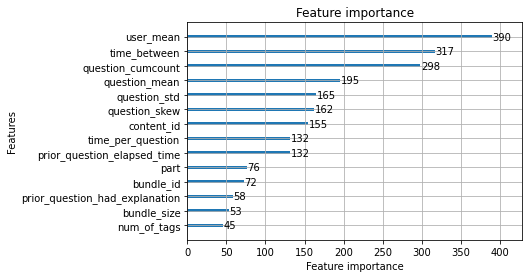

In [18]:
lgb.plot_importance(lgb_booster)

In [ ]:
lgb_booster = lgb.Booster(model_file=path.stem + '/models/lgb_p2_50')

In [ ]:
xgb_preds_p1 = xgb_booster.predict(dval_p1)
xgb_preds_p2 = xgb_booster.predict(dval_p2)

In [ ]:
xgb_preds_p2

In [ ]:
lgb_preds_p1 = lgb_booster.predict(val_p1[features])
lgb_preds_p2 = lgb_booster.predict(val_p2[features])

In [ ]:
lgb_preds_p2

In [ ]:
print("xgb --> val_p1: {:.4}, val_p2: {:.4}".format(
    roc_auc_score(val_p1[target], xgb_preds_p1),
    roc_auc_score(val_p2[target], xgb_preds_p2)))

In [ ]:
print("lbm --> val_p1: {:.4}, val_p2: {:.4}".format(
    roc_auc_score(val_p1[target], lgb_preds_p1),
    roc_auc_score(val_p2[target], lgb_preds_p2)))

In [ ]:
print("rf --> val_p1: {:.4}, val_p2: {:.4}".format(
    roc_auc_score(val_p1[target], rf_preds_p1),
    roc_auc_score(val_p2[target], rf_preds_p2)))

In [ ]:
w = 0.1
avg_preds_p1 = xgb_preds_p1*w + lgb_preds_p1*(1-w)
avg_preds_p2 = xgb_preds_p2*w + lgb_preds_p2*(1-w)
print("avg (xgb:{}) --> val_p1: {:.4}, val_p2: {:.4}".format(
    w,
    roc_auc_score(val_p1[target], avg_preds_p1),
    roc_auc_score(val_p2[target], avg_preds_p2)))

In [ ]:
w = 0.2
avg_preds_p1 = xgb_preds_p1*w + lgb_preds_p1*(1-w)
avg_preds_p2 = xgb_preds_p2*w + lgb_preds_p2*(1-w)
print("avg (xgb:{}) --> val_p1: {:.4}, val_p2: {:.4}".format(
    w,
    roc_auc_score(val_p1[target], avg_preds_p1),
    roc_auc_score(val_p2[target], avg_preds_p2)))

In [ ]:
w = 0.3
avg_preds_p1 = xgb_preds_p1*w + lgb_preds_p1*(1-w)
avg_preds_p2 = xgb_preds_p2*w + lgb_preds_p2*(1-w)
print("avg (xgb:{}) --> val_p1: {:.4}, val_p2: {:.4}".format(
    w,
    roc_auc_score(val_p1[target], avg_preds_p1),
    roc_auc_score(val_p2[target], avg_preds_p2)))

In [ ]:
w = 0.4
avg_preds_p1 = xgb_preds_p1*w + lgb_preds_p1*(1-w)
avg_preds_p2 = xgb_preds_p2*w + lgb_preds_p2*(1-w)
print("avg (xgb:{}) --> val_p1: {:.4}, val_p2: {:.4}".format(
    w,
    roc_auc_score(val_p1[target], avg_preds_p1),
    roc_auc_score(val_p2[target], avg_preds_p2)))

In [ ]:
w = 0.5
avg_preds_p1 = xgb_preds_p1*w + lgb_preds_p1*(1-w)
avg_preds_p2 = xgb_preds_p2*w + lgb_preds_p2*(1-w)
print("avg (xgb:{}) --> val_p1: {:.4}, val_p2: {:.4}".format(
    w,
    roc_auc_score(val_p1[target], avg_preds_p1),
    roc_auc_score(val_p2[target], avg_preds_p2)))

In [ ]:
w = 0.6
avg_preds_p1 = xgb_preds_p1*w + lgb_preds_p1*(1-w)
avg_preds_p2 = xgb_preds_p2*w + lgb_preds_p2*(1-w)
print("avg (xgb:{}) --> val_p1: {:.4}, val_p2: {:.4}".format(
    w,
    roc_auc_score(val_p1[target], avg_preds_p1),
    roc_auc_score(val_p2[target], avg_preds_p2)))

In [ ]:
train_p1

In [ ]:
train_p1[train_p1['user_id']==13134].tail(3)

In [ ]:
train_p2[train_p2['user_id']==13134].tail(3)

In [ ]:
val_p1[val_p1['user_id']==13134].tail(3)

In [ ]:
val_p2[val_p2['user_id']==13134].head(3)

In [3]:
data = pd.read_feather(path/'data.feather')

In [4]:
data = data.drop(index=data[data['content_type_id']==1].index).reset_index(drop=True)

In [5]:
data.shape

(99271300, 8)

In [6]:
data.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,1,NaN,<NA>
1,56943,115,5716,0,2,1,37000.0,False
2,118363,115,128,0,0,1,55000.0,False
3,131167,115,7860,0,3,1,19000.0,False
4,137965,115,7922,0,4,1,11000.0,False


In [7]:
user_ = data[['user_id', 'answered_correctly']].groupby('user_id').agg(['count', 'mean'])
user_.columns=['a_count', 'a_mean']
user_ = user_.reset_index()
class_count = user_['a_count'].value_counts().to_frame()
class_count.columns = ['class_count']
user_ = user_.join(class_count, on='a_count')

In [8]:
user_

,user_id,a_count,a_mean,class_count
0,115,46,0.695652,1086
1,124,30,0.233333,62422
2,2746,19,0.578947,5309
3,5382,125,0.672000,414
4,8623,109,0.642202,498
...,...,...,...,...
393651,2147470770,226,0.765487,191
393652,2147470777,752,0.691489,38
393653,2147481750,50,0.760000,7348
393654,2147482216,275,0.643636,159


In [9]:
val_users=[]

In [10]:
# add 100 users with class_count 1 (635612 rows)
val_users.extend(user_[user_['class_count']==1][:100]['user_id'].to_list())
# val_users.sort()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# set 1% as new users
_, new_user_idx = train_test_split(user_[user_['class_count']!=1],
                              test_size=0.01,
                              stratify=user_[user_['class_count']!=1]['class_count'],
                              random_state=2020)

In [13]:
# add 3917 users as new users with stratified class_count (863668 rows)
val_users.extend(new_user_idx['user_id'].to_list())

In [14]:
len(val_users), 635612 + 863668

(4017, 1499280)

In [15]:
# set 30% as existing users
_, users_to_split = train_test_split(user_[(user_['class_count']!=1)&(~user_['user_id'].isin(val_users))],
                              test_size=0.3,
                              stratify=user_[(user_['class_count']!=1)&(~user_['user_id'].isin(val_users))]['class_count'],
                              random_state=2020)

In [16]:
users_to_split

,user_id,a_count,a_mean,class_count
196104,1073806349,479,0.561587,88
332715,1817853928,64,0.703125,1015
304037,1661813013,210,0.680952,265
333477,1821791870,30,0.133333,62422
84765,464265306,17,0.647059,17137
...,...,...,...,...
71187,390516538,567,0.772487,61
302574,1653578093,722,0.373961,55
30186,165729932,36,0.333333,1755
155220,851106025,81,0.629630,851


In [17]:
len(users_to_split['user_id'].unique())

116335

In [18]:
data_ = data.loc[data['user_id'].isin(users_to_split['user_id'])].copy()

In [19]:
data_.shape

(25564923, 8)

In [20]:
len(data_['user_id'].unique())

116335

In [21]:
def get_val_idx(df, n_iter=17):
        """Get validation idx."""
        
        counter = 0
        val_idx = []
        df['user_filter'] = (df[['user_id', 'task_container_id']].groupby('user_id').transform('nunique').values > n_iter)
    
        while counter < n_iter:
            train_trans = df.loc[df['user_filter'], ['user_id', 'timestamp']].groupby('user_id').transform('max').values.squeeze()
            val_filter = (train_trans == df.loc[df['user_filter'], 'timestamp'].values)
            val_idx.extend(df.loc[df['user_filter']][val_filter].index.to_list())
            val_idx.sort()
            
            df = df.drop(df[df['user_filter']][val_filter].index)
            
            counter += 1
    
        return val_idx

In [22]:
existing_users_idx = get_val_idx(data_, n_iter=20)

In [23]:
existing_users_idx[:5]

[22, 23, 24, 25, 26]

In [24]:
len(existing_users_idx)

1934444

In [25]:
1499280 + 1934444

3433724

In [26]:
val_df = data.loc[existing_users_idx]

In [27]:
val_df.shape

(1934444, 8)

In [28]:
len(val_df['user_id'].unique())

78633

In [29]:
train_df = data[data['user_id'].isin(users_to_split['user_id'])].drop(data.loc[existing_users_idx].index).reset_index(drop=True)

In [30]:
common_users = set(train_df['user_id'].unique()).intersection(val_df['user_id'].unique())

In [31]:
only_in_train = set(train_df['user_id'].unique()).difference(common_users)

In [32]:
only_in_val = set(val_df['user_id'].unique()).difference(common_users)

In [33]:
len(common_users), len(only_in_train), len(only_in_val)

(78633, 37702, 0)

In [34]:
len(common_users) + len(only_in_train) + len(only_in_val)

116335

In [35]:
train_df.shape, val_df.shape

((23630479, 8), (1934444, 8))

In [36]:
check = train_df.loc[train_df['user_id'].isin(common_users),['user_id', 'timestamp']].groupby('user_id').max().join(
    val_df.loc[val_df['user_id'].isin(common_users), ['user_id', 'timestamp']].groupby('user_id').min(),rsuffix='_val')

In [37]:
check.shape

(78633, 2)

In [38]:
check

,timestamp,timestamp_val
user_id,,
115,510583,534187
5382,553688832,553766282
46886,13966278,13990828
50132,836900379,1085142294
51285,22455,41947
...,...,...
2147402806,267875051,267973520
2147413636,22532643875,22532779286
2147464207,32209963,32560303


In [39]:
(check['timestamp'] > check['timestamp_val']).sum()

0

In [40]:
val_df = val_df.append(data[data['user_id'].isin(val_users)]).sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

In [41]:
val_df.shape

(3433724, 8)

In [42]:
questions_df = pd.read_csv(path/'questions.csv')

In [43]:
len(questions_df['question_id'].unique())

13523

In [44]:
len(data['content_id'].unique())

13523

In [45]:
len(train_df['content_id'].unique())

13511

In [46]:
len(val_df['content_id'].unique())

13485

In [47]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,1,NaN,<NA>
1,56943,115,5716,0,2,1,37000.0,False
2,118363,115,128,0,0,1,55000.0,False
3,131167,115,7860,0,3,1,19000.0,False
4,137965,115,7922,0,4,1,11000.0,False


In [48]:
train_df.to_feather(path/'train_m.feather')
val_df.to_feather(path/'val_m.feather')